In [29]:
### About the notebook
"""
This notebook is a PyTorch implementation of convolutional neural networks
The used dataset is the MNIST handwritten digits dataset
"""

'\nThis notebook is a PyTorch implementation of convolutional neural networks\nThe used dataset is the MNIST handwritten digits dataset\n'

In [2]:
## Import the required modules (libraries)

## for the MNIST dataset
from torchvision import datasets 
## ToTensor() is to convert PIL image to tensor of numbers of shape (channels , height , width)
## Normalize is used to rescale the numbers (pixels of the image in our case)
## PIL image is the format of the saved images in the MNIST dataset
## PIL image is in shape of (height , width , channel)
from torchvision.transforms import ToTensor , Normalize , Compose
## For visualization of the data
import matplotlib.pyplot as plt
## For tensor operations
import torch
## Needed for building the neural network
from torch import nn 
## Dividing the dataset into batches
from torch.utils.data import DataLoader
## Needed for using tensorboard to view results of training
from torch.utils.tensorboard import SummaryWriter
## Needed for the max pooling layer
import torch.nn.functional as F

In [3]:
## Download the MNIST dataset
## before we download , let us consider specifying the transformations to be applied
## Normalize has two parameters , mean and standard deviation
transform = Compose([ToTensor(),
                     Normalize((0.5,), (0.5,)),
                              ])
## Train dataset
train_data = datasets.MNIST(
    root = 'data', # where dataset is stored. it will be in data folder in the same directory as your notebook file
    train = True,  # it is training dataset                    
    transform = transform, # transform the images after downloading 
    download = True) #download if the dataset is not downloaded

## Test dataset
## Same as training data, but the train parameter is set to false to indicate this is testing dataset
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transform
)

In [4]:
## Check the dimensions of train dataset
## It has 60000 grayscale images (single channel) of shape 28 by 28
train_data.data.size()

torch.Size([60000, 28, 28])

In [5]:
## Check the dimensions of the test dataset
test_data.data.size()

torch.Size([10000, 28, 28])

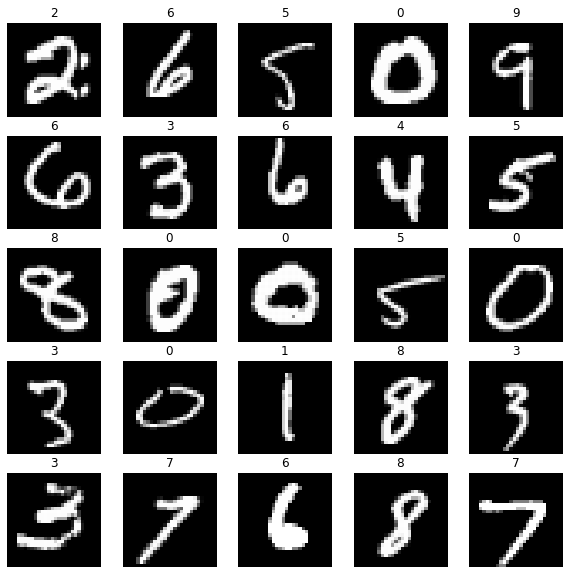

In [6]:
## display some images
figure = plt.figure(figsize=(10, 10)) ## create a main figure object
cols, rows = 5, 5 ## grid of 5  by 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() ## create a random index
    img, label = train_data[sample_idx] ## find the corresponding image with their labels
    figure.add_subplot(rows, cols, i) ## adding subplot to the main figure
    plt.title(label) # image title is the label
    plt.axis("off") # disable the axis
    plt.imshow(img.squeeze(), cmap="gray") # show the image in grayscale
plt.show()

In [7]:
## Now we have the train and test datasets and both are normalized
## We can start building different models and explore the performance
## Build a simple neural network (NN) by inheriting from the module class

class simple_nn(nn.Module):
    def __init__(self , input_size , hidden_layer , num_of_classes):
        super(simple_nn, self).__init__()
        self.flatten = nn.Flatten() ## convert input image to tensor of shape (batch_size , 784)(784 is just 28*28)
        self.linear_relu_stack = nn.Sequential( ## stacking linear layers
            nn.Linear(input_size, hidden_layer), ## first hidden layer 
            nn.ReLU(), ## ReLU activation function
            nn.Linear(hidden_layer, int(hidden_layer/4)), ## second hidden layer
            nn.ReLU(),
            nn.Linear(int(hidden_layer/4), int(hidden_layer/8)), ## third hidden layer
            nn.ReLU(),
            nn.Linear(int(hidden_layer/8), int(hidden_layer/8)), ## fourth hidden layer
            nn.ReLU(),
            nn.Linear(int(hidden_layer/8), num_of_classes), ## output layer
            #nn.LogSoftmax(dim=1) ## for generating predictions' probabilities
        )
    ## To produce predictions by applying feedforward process (feeding input to the model)
    def forward(self, x): 
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
## Size of the input tensor 
input_size = 28 * 28
## Hidden layer size
hidden_layer = 256
## Size of the output layer , since we have 10 digits (0 - 9)
num_of_classes = 10

In [9]:
## For faster training, we will move the model to the GPU (if found)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
## create a nn model
nn_model = simple_nn(input_size , hidden_layer , num_of_classes).to(device)
## view the model
print(nn_model)

simple_nn(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [10]:
## Define the loss function
## It is the cross entropy loss
## We can also use the negative log likelihood given that the activation of the last layer is LogSoftmax
nn_loss = nn.CrossEntropyLoss()
## Define the optimizer for reducing the loss function
## It is stochastic gradient descent
## Define also the learning rate and the momentum
learning_rate = 0.003
momentum = 0.9
optimizer = torch.optim.SGD(nn_model.parameters(), ## parameters to optimize
                         lr = learning_rate, ## learning rate
                         momentum = momentum ## momentum
                        )

In [11]:
## It is better to divide the dataset into batches for faster training and convergence
## Batching the training dataset
## Define the batch size (number of images in each batch)
batch_size = 64
train_loader = DataLoader(train_data, 
                          batch_size = batch_size,
                          shuffle=True ## randomly re-ordering the samples
                         )

## Batching the testing dataset
test_loader = DataLoader(test_data, 
                         batch_size = batch_size, 
                         shuffle=True)


In [12]:
# You can check a single batch of any dataloader (train or test)
imgs , lbls = next(iter(train_loader))
print(imgs.size())

torch.Size([64, 1, 28, 28])


In [13]:
## This is the writer for recording the results to the tensorboard
writer = SummaryWriter('runs/nn_mnist')

In [14]:
## Define a function to calculate the accuracy
## We will use a function taken from this code
## Link : https://github.com/BunsenFeng/BotRGCN/blob/main/BotRGCN/gat.py

def get_accuracy(probs, labels):
    probs = torch.argmax(probs, dim = 1)
    correct = 0
    for i in range(len(probs)):
        if probs[i] == labels[i]:
            correct += 1
    return correct / len(probs)


In [17]:
## Now we can train our model
## Specify the number of epochs (training iterations)
epochs = 10
## Define a training function
def train(model , train_loader , test_loader , epochs , optimizer , nn_loss , device):
    for i in range(epochs):
        train_loss = 0 ## loss in each epoch
        train_acc = 0 ## accuracy in each epoch
        for train_x , train_y in train_loader:
            ## Move the batch to the GPU
            train_x = train_x.to(device)
            train_y = train_y.to(device)
            
            ## Set the model mode to training
            model.train()
            
            ## Zerowise the gradient to prevent gradient accumulation
            optimizer.zero_grad(
            )
            ## Feedforward process
            y_hat = model(train_x)
            
            ## Calculate the loss
            loss = nn_loss(y_hat , train_y)
            acc = get_accuracy(y_hat , train_y)
            
            ## Calculate the gradients
            loss.backward()
            
            ## Update the parameters
            optimizer.step()
            
            ## Add to the epoch loss and accuracy
            train_loss = train_loss + loss.item()
            train_acc = train_acc + acc
        
        ## Evaluate the model on the testing dataset
        test_acc = 0
        for test_x , test_y in test_loader:
            ## set the model mode to testing or evaluating
            model.eval()
            test_x = test_x.to(device)
            test_y = test_y.to(device)
            y_hat = model(test_x)
            acc = get_accuracy(y_hat , test_y)
            test_acc = test_acc + acc
        
        ## Print the results 
        ## The loss and accuracy are averaged over the batches in the training and testing datasets
        print(f'Epoch: {i:03d} , Train Loss: {train_loss/len(train_loader):.4f} , Train Acc: {train_acc/len(train_loader):.4f}  , Test Acc: {test_acc/len(test_loader):.4f}')
        
        ## Add train loss, train accuracy , and test accuracy to the tensorboard
        writer.add_scalar('Train/loss', train_loss/len(train_loader) , i) 
        writer.add_scalar('Train/acc', train_acc/len(train_loader) , i)  
        writer.add_scalar('Test/acc', test_acc/len(test_loader) , i)  
        
            
    

In [18]:
## Run the training function
train(nn_model , train_loader , test_loader , epochs , optimizer , nn_loss , device)

Epoch: 000 , Train Loss: 1.2987 , Train Acc: 0.5418  , Test Acc: 0.8618
Epoch: 001 , Train Loss: 0.3408 , Train Acc: 0.8983  , Test Acc: 0.9271
Epoch: 002 , Train Loss: 0.2031 , Train Acc: 0.9386  , Test Acc: 0.9511
Epoch: 003 , Train Loss: 0.1519 , Train Acc: 0.9545  , Test Acc: 0.9585
Epoch: 004 , Train Loss: 0.1232 , Train Acc: 0.9637  , Test Acc: 0.9552
Epoch: 005 , Train Loss: 0.1068 , Train Acc: 0.9674  , Test Acc: 0.9658
Epoch: 006 , Train Loss: 0.0910 , Train Acc: 0.9723  , Test Acc: 0.9674
Epoch: 007 , Train Loss: 0.0810 , Train Acc: 0.9751  , Test Acc: 0.9730
Epoch: 008 , Train Loss: 0.0706 , Train Acc: 0.9787  , Test Acc: 0.9676
Epoch: 009 , Train Loss: 0.0626 , Train Acc: 0.9805  , Test Acc: 0.9716


In [19]:
## Let us try using CNN
## Create the CNN model 
class mycnn(nn.Module):
    def __init__(self , in_channels , out_channels ,kernel_size ,hidden_size ,   num_of_classes):
        super(mycnn, self).__init__()
        ## A 2d convolution layer
        self.conv1 = nn.Conv2d(in_channels , ## number of channels for input image
                               out_channels[0] , ## number of channels for output image
                               kernel_size,  ## size of the filter kernel
                               stride = 1 , ## movement of the filter kernel
                               padding = 2  ## padding added to the four sides of the image 
                              )
        self.conv2 = nn.Conv2d(out_channels[0] , 
                               out_channels[1] , 
                               kernel_size , 
                               stride = 1 , 
                               padding = 2
                              )
        self.fc1 = nn.Linear(out_channels[1] * 7 * 7 , hidden_size)
        self.fc2 = nn.Linear(hidden_size , num_of_classes)
        
        
        
    def forward(self , x):
        ## 2d max pooling layer of size 2 by 2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        ## Flatten except for the batch size dimension  (1 is the starting dimension)
        ## Output of flatten will have the shape of (batch_size , 32 * 7 *7)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        
        

In [20]:
in_channels = 1 ## channels of the input
out_channels = [16 , 32] ## channels of the output
kernel_size = 5 ## size of the filter kernel
hidden_size = 256 ## size of the hidden layer

In [22]:
## Now let us create a CNN model
cnn_model = mycnn(in_channels , out_channels , kernel_size  ,  hidden_size  ,  num_of_classes).to(device)
print(cnn_model)

mycnn(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [23]:
## For storing the results of the CNN model
writer = SummaryWriter('runs/cnn_mnist')

In [24]:
## Configuration of the CNN model
cc_learning_rate = 0.01
## Here we used Adam optimizer
cnn_optim = torch.optim.Adam(cnn_model.parameters(),
                         lr = cc_learning_rate)

In [25]:
# Run the training function using the CNN
train(cnn_model , train_loader , test_loader , epochs , cnn_optim , nn_loss , device)

Epoch: 000 , Train Loss: 0.2823 , Train Acc: 0.9141  , Test Acc: 0.9361
Epoch: 001 , Train Loss: 0.1480 , Train Acc: 0.9586  , Test Acc: 0.9641
Epoch: 002 , Train Loss: 0.1333 , Train Acc: 0.9617  , Test Acc: 0.9654
Epoch: 003 , Train Loss: 0.1307 , Train Acc: 0.9632  , Test Acc: 0.9427
Epoch: 004 , Train Loss: 0.1354 , Train Acc: 0.9616  , Test Acc: 0.9579
Epoch: 005 , Train Loss: 0.1295 , Train Acc: 0.9639  , Test Acc: 0.9610
Epoch: 006 , Train Loss: 0.1252 , Train Acc: 0.9649  , Test Acc: 0.9689
Epoch: 007 , Train Loss: 0.1247 , Train Acc: 0.9647  , Test Acc: 0.9602
Epoch: 008 , Train Loss: 0.1237 , Train Acc: 0.9657  , Test Acc: 0.9665
Epoch: 009 , Train Loss: 0.1238 , Train Acc: 0.9656  , Test Acc: 0.9600


In [27]:
# Run the tensorboard interface
%load_ext tensorboard
%tensorboard --logdir runs --port 8080

Reusing TensorBoard on port 8080 (pid 26580), started 10:46:06 ago. (Use '!kill 26580' to kill it.)

In [ ]:
## Note
"""
Maybe you have noticed that the testing accuracy is higher than the training accuracy in both NN and CNN
This can be due to different reasons
1 - Dropout technique
    because this technique has a different behaviour in training (disabling the neurons) and testing (enabling the neurons)
2 - The samples in the testing dataset are simple and easy to predict, unlike those that belong to the training dataset.
    This can be solved by applying k-fold cross validation and see if the trend keeps on comming
"""